In [1]:
import timm

model_name='efficientnet_b2'
checkpoint_path=''
pretrained=True

model = timm.create_model(
    model_name,
    num_classes=1000,
    in_chans=3,
    pretrained=pretrained,
    checkpoint_path=checkpoint_path)

In [5]:
model

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
   

In [9]:
from tddl.factorizations import number_layers
from tddl.factorizations import factorize_network
from tddl.factorizations import listify_numbered_layers

pretrained_numbered_layers = number_layers(model)
pretrained_numbered_layers

{'conv_stem': (0,
  Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)),
 'bn1': (1,
  BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
 'act1': (2, SiLU(inplace=True)),
 'blocks': (3,
  {'0': (4,
    {'0': (5,
      {'conv_dw': (6,
        Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)),
       'bn1': (7,
        BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
       'act1': (8, SiLU(inplace=True)),
       'se': (9,
        {'conv_reduce': (10, Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))),
         'act1': (11, SiLU(inplace=True)),
         'conv_expand': (12, Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))),
         'gate': (13, Sigmoid())}),
       'conv_pw': (14,
        Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)),
       'bn2': (15,
        BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
 

In [11]:
layer_names = ['conv_stem','conv_dw','conv_pw', 'conv_reduce', 'conv_expand','conv_pwl','conv_head']
pretrained_conv_layers = listify_numbered_layers(pretrained_numbered_layers, layer_names=layer_names)
pretrained_conv_layers

[('conv_stem',
  0,
  Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)),
 ('conv_dw',
  6,
  Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)),
 ('conv_reduce', 10, Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))),
 ('conv_expand', 12, Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))),
 ('conv_pw',
  14,
  Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)),
 ('conv_dw',
  18,
  Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)),
 ('conv_reduce', 22, Conv2d(16, 4, kernel_size=(1, 1), stride=(1, 1))),
 ('conv_expand', 24, Conv2d(4, 16, kernel_size=(1, 1), stride=(1, 1))),
 ('conv_pw',
  26,
  Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)),
 ('conv_pw',
  31,
  Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)),
 ('conv_dw',
  34,
  Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=96, bias=False)),
 ('conv_reduce', 38, 

In [13]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

In [16]:
params_conv = {
    'name': [],
    'nr': [],
    'parameter_count': [],
    'trainable_parameter_count': [],
}

for layer in pretrained_conv_layers:
    name = layer[0]
    nr = layer[1]
    module = layer[2]

    parameter_count = count_parameters(module)
    trainable_parameter_count = count_trainable_parameters(module)
    if parameter_count != trainable_parameter_count:
        print(name, nr)

    params_conv['name'].append(name)
    params_conv['nr'].append(nr)
    params_conv['parameter_count'].append(parameter_count)
    params_conv['trainable_parameter_count'].append(trainable_parameter_count)

In [20]:
import pandas as pd
param_count = pd.DataFrame(data=params_conv)
param_count.set_index('nr', inplace=True)
param_count

,name,parameter_count,trainable_parameter_count
nr,,,
0,conv_stem,864,864
6,conv_dw,288,288
10,conv_reduce,264,264
12,conv_expand,288,288
14,conv_pw,512,512
...,...,...,...
319,conv_dw,19008,19008
323,conv_reduce,185944,185944
325,conv_expand,187968,187968


In [30]:
grouped_count = param_count.groupby(by='name')

name
conv_dw        AxesSubplot(0.125,0.125;0.775x0.755)
conv_expand    AxesSubplot(0.125,0.125;0.775x0.755)
conv_head      AxesSubplot(0.125,0.125;0.775x0.755)
conv_pw        AxesSubplot(0.125,0.125;0.775x0.755)
conv_pwl       AxesSubplot(0.125,0.125;0.775x0.755)
conv_reduce    AxesSubplot(0.125,0.125;0.775x0.755)
conv_stem      AxesSubplot(0.125,0.125;0.775x0.755)
Name: parameter_count, dtype: object

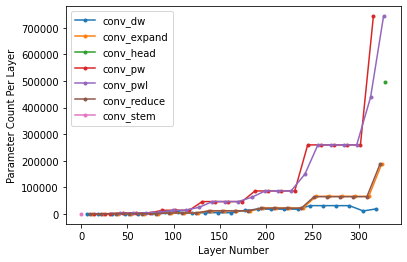

In [31]:
grouped_count['parameter_count'].plot(legend=True, style=".-", ylabel='Parameter Count Per Layer', xlabel='Layer Number')

name
conv_dw        AxesSubplot(0.125,0.125;0.775x0.755)
conv_expand    AxesSubplot(0.125,0.125;0.775x0.755)
conv_head      AxesSubplot(0.125,0.125;0.775x0.755)
conv_pw        AxesSubplot(0.125,0.125;0.775x0.755)
conv_pwl       AxesSubplot(0.125,0.125;0.775x0.755)
conv_reduce    AxesSubplot(0.125,0.125;0.775x0.755)
conv_stem      AxesSubplot(0.125,0.125;0.775x0.755)
Name: parameter_count, dtype: object

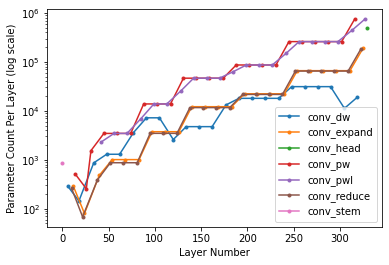

In [34]:
grouped_count['parameter_count'].plot(legend=True, style=".-", ylabel='Parameter Count Per Layer (log scale)', xlabel='Layer Number', logy=True)

In [3]:
model_name='efficientnet_b0'
checkpoint_path=''
pretrained=True

model_b0 = timm.create_model(
    model_name,
    num_classes=1000,
    in_chans=3,
    pretrained=pretrained,
    checkpoint_path=checkpoint_path)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /home/jetzeschuurman/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


In [4]:
model_b0

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
   